# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
 
### Purpose

We have shown that reducing the number of outputs to 8 was a good choice but wasn't enough to prevent information leakage in a general context, as this output could still be used to identify font families quite precisely. We will now try to undermine specifically the font family recognition task.

In this setting, we call `Q` the quadratic part, `Cc` the CNN on top of `Q` used to predict characters and `Cf` the CNN for predicting families. The network will be structured as follows:
```
  |
  Q
 / \
Cf  Cc
|   |
```

We will do a 3-phase process:
 - `Optimize: Q + Cc`
 - `Optimize: Freezed(Q) + Cf`
 - `Perturb : Q + Freezed(Cf)`

In [1]:
FORCE_RETRAIN = False  # Should you retrain models that you already trained and stored.
# Set it to True if you change of model.

# 1. Main task


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [2]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [3]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [4]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN. Also we have defined a freeze / unfreeze functionality.

In [5]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- Junction
        self.jct = nn.Linear(8, 784)
        
        # --- CNN for characters
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, N_CHARS)
        
        # --- CNN for font families
        self.conv3 = nn.Conv2d(1, 20, 5, 1)
        self.conv4 = nn.Conv2d(20, 50, 5, 1)
        self.fc3 = nn.Linear(4*4*50, 500)
        self.fc4 = nn.Linear(500, N_FONTS)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
    def conv_font(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'font':
            layers = [self.conv3, self.conv4, self.fc3, self.fc4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input. In the training phase we execute the 3 stesp as described aboved. In the test function, we juste test the performance for the main and collateral tasks.

In [6]:
def train(args, model, train_loader, optimizer, epoch, perturbate=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        # Phase 1: Optimise Q + Cc
        optimizer.zero_grad()
        output = model.forward_char(data)
        loss_char = F.nll_loss(output, target_char)
        loss_char.backward()
        optimizer.step()
        
        # Phase 2: Optimise Freezed(Q) + Cf
        model.freeze('quad')
        optimizer.zero_grad()
        output = model.forward_font(data)
        loss_font = F.nll_loss(output, target_font)
        loss_font.backward()
        optimizer.step()
        model.unfreeze()
        
        if perturbate:
            # Phase 3: Perturb Q + Freezed(Cf)
            model.freeze('font')
            optimizer.zero_grad()
            output = model.forward_font(data)
            fake_target = torch.tensor(np.random.randint(0, N_FONTS, len(data)))
            fake_loss = F.nll_loss(output, fake_target)
            fake_loss.backward()
            optimizer.step()
            model.unfreeze()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char.item(), loss_font.item()))

In [7]:
def test(args, model, test_loader):
    model.eval()
    #test_loss = 0
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            #test_loss += F.nll_loss(output, target_char, reduction='sum').item()  
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            output = model.forward_font(data)
            #test_loss += F.nll_loss(output, target_font, reduction='sum').item()  
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    #test_loss /= len(test_loader.dataset)

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

Now we can handle the main function. The only thing that really changes is that we now want to have both labels associated to a input item.

In [8]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset

Last the main function !

In [9]:
def main(perturbate=True):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, train_loader, optimizer, epoch, perturbate)
        test_perf_char, test_perf_font = test(args, model, test_loader)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font, model

In [10]:
test_perfs_char_clean, test_perfs_font_clean, model_clean = main(perturbate=False)
test_perfs_char_perturbate, test_perfs_font_perturbate, model_perturbate = main(perturbate=True)

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.267609 Loss Font: 1.610325
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.253022 Loss Font: 1.607537
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.261112 Loss Font: 1.621270
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.254210 Loss Font: 1.608371
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 3.266149 Loss Font: 1.605150
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 3.250923 Loss Font: 1.610914
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 3.257170 Loss Font: 1.608244
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 3.252907 Loss Font: 1.606738
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 3.237244 Loss Font: 1.606526
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 3.246484 Loss Font: 1.604254

Test set: Accuracy Char : 597/10000 (5.97%)
          Accuracy Font : 2109/10000 (21.09%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 3.252859 Loss Font: 1.603148
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.197180 Loss Font: 0.487915

Test set: Accuracy Char : 9197/10000 (91.97%)
          Accuracy Font : 7541/10000 (75.41%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.267609 Loss Font: 1.610325
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.252941 Loss Font: 1.608624
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.261114 Loss Font: 1.610602
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.254203 Loss Font: 1.607546
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 3.266158 Loss Font: 1.606779
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 3.250767 Loss Font: 1.610377
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 3.256921 Loss Font: 1.607724
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 3.252955 Loss Font: 1.607313
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 3.236990 Loss Font: 1.608920
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 3.246630 Loss Font: 1.605792

Test set: Accuracy Char : 570/10000 

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.235401 Loss Font: 1.011386
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.313565 Loss Font: 1.126480
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.158137 Loss Font: 1.052152
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.252728 Loss Font: 1.063932

Test set: Accuracy Char : 9234/10000 (92.34%)
          Accuracy Font : 6455/10000 (64.55%)
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.267609 Loss Font: 1.610325
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.253022 Loss Font: 1.607537
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.261112 Loss Font: 1.621270
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 3.254210 Loss Font: 1.608371
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 3.266149 Loss Font: 1.605150
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 3.250923 Loss Font: 1.610914
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 3.257170 Loss Font: 1.608244
Train Epoch: 1 [44800/60000 (75%)]

Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.107494 Loss Font: 0.559433
Train Epoch: 10 [25600/60000 (43%)]	Loss Char: 0.224728 Loss Font: 0.584586
Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.214888 Loss Font: 0.618040
Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.215357 Loss Font: 0.369177
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.304249 Loss Font: 0.610886
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.202504 Loss Font: 0.498513
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.197180 Loss Font: 0.487915

Test set: Accuracy Char : 9197/10000 (91.97%)
          Accuracy Font : 7541/10000 (75.41%)


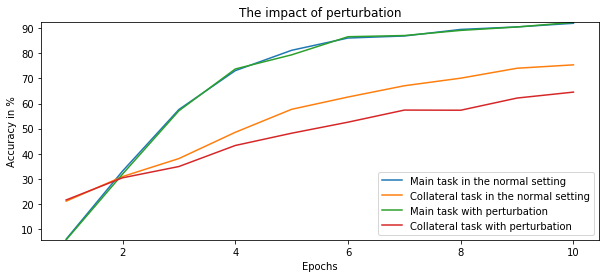

In [11]:
results = {
    "Main task in the normal setting": test_perfs_char_clean,
    "Collateral task in the normal setting": test_perfs_font_clean,
    "Main task with perturbation": test_perfs_char_perturbate,
    "Collateral task with perturbation": test_perfs_font_perturbate,
}
show_results(results, "The impact of perturbation")

### Conclusion

As we see the results that we get we can favour the main task against the second one: the main task is not affected with an accuracy around `92%` while the accuracy on the collateral drops from `75.5%` to `64.55%`.
However the collateral task is still not too bad. As the computation is a bit heavy, we'll switch in part 9 to lighter models with small feed forward networks and try to improve the sabotage.